In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [9]:
#Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

In [4]:
#reading the csv file as a pandas dataframe
nps_data = pd.read_csv('/kaggle/input/npsbank/NPStimeseries.csv')
nps_data.head()

,ID,Market,Survey date,Customer Name,Month,Quarter,NPS
0,1000,US,01/09/2021,Krista Richards,9,3,10
1,1001,MEX,07/11/2021,Monica King,11,4,9
2,1002,UK,25/12/2021,Ricky Armstrong,12,4,0
3,1003,UK,01/10/2021,Andrea Foley,10,4,10
4,1004,UK,01/03/2021,Jerry Garcia,3,1,8


In [4]:
#Structure of the data
nps_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ID             5000 non-null   int64 
 1   Market         5000 non-null   object
 2   Survey date    5000 non-null   object
 3   Customer Name  5000 non-null   object
 4   Month          5000 non-null   int64 
 5   Quarter        5000 non-null   int64 
 6   NPS            5000 non-null   int64 
dtypes: int64(4), object(3)
memory usage: 273.6+ KB


In [5]:
#Analysing the shape
nps_data.shape

(5000, 7)

In [6]:
# Counting the unique values in the clients column and showing the number of times that one customer reponded the survey
nps_data['Customer Name'].value_counts()

Customer Name
Amanda Smith         4
Michael Williams     4
David Johnson        3
Alexander Miller     3
Brian Davis          3
                    ..
Jeffery Mcfarland    1
Melissa Cox          1
Sherry Delacruz      1
James Mccullough     1
Edwin Zavala         1
Name: count, Length: 4829, dtype: int64

In [7]:
# Counting the unique values in the NPS Score column and showing the number of times that the score was choosed
nps_data['NPS'].value_counts()

NPS
10    1597
9      712
8      680
0      565
5      321
7      292
6      206
3      181
1      172
2      154
4      120
Name: count, dtype: int64

In [5]:
#Creating a new column with the NPS profile of each client, to facilitate calculating NPS
def define_profile(score):
    if score <= 6:
        return 'Detractor'
    elif score <= 8:
        return 'Passive'
    else:
        return 'Promoter'

#Applying the function to create the new "Profile" column
nps_data['Profile'] = nps_data['NPS'].apply(define_profile)
nps_data.head()

,ID,Market,Survey date,Customer Name,Month,Quarter,NPS,Profile
0,1000,US,01/09/2021,Krista Richards,9,3,10,Promoter
1,1001,MEX,07/11/2021,Monica King,11,4,9,Promoter
2,1002,UK,25/12/2021,Ricky Armstrong,12,4,0,Detractor
3,1003,UK,01/10/2021,Andrea Foley,10,4,10,Promoter
4,1004,UK,01/03/2021,Jerry Garcia,3,1,8,Passive


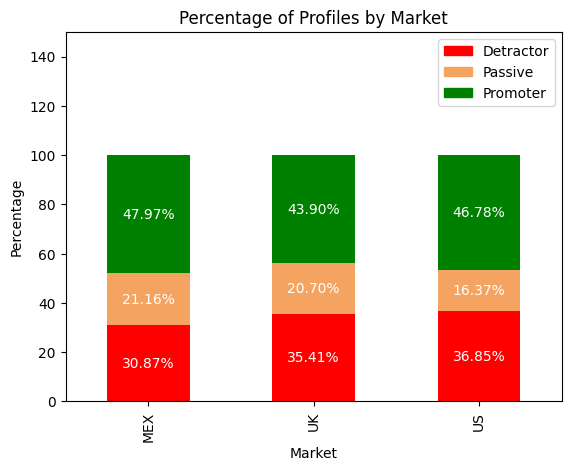

In [11]:
#Ploting a graph with the % of each nps profile per market

#Calculating the % of each profile by market
profile_percentage = nps_data.groupby(['Market', 'Profile']).size() / nps_data.groupby('Market').size() * 100
profile_percentage = profile_percentage.unstack().fillna(0)

#Defining colors for profiles
colors = {'Promoter': 'green', 'Passive': 'sandybrown', 'Detractor': 'red'}

#Ploting the stacked bar chart
ax = profile_percentage.plot(kind='bar', stacked=True, color=[colors[col] for col in profile_percentage.columns])

plt.xlabel('Market')
plt.ylabel('Percentage')
plt.title('Percentage of Profiles by Market')

#Displaying legend with custom labels
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=[plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels], labels=labels)

#Adding labels with percentage values on top of the bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f%%', label_type='center', fontsize=10, color='white')
    
plt.ylim(0, 150)
plt.show()

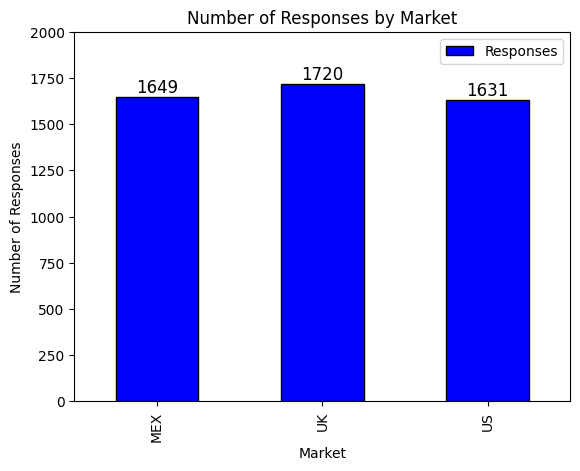

In [12]:
#plting a graphic to see how many responses each market has

#group by Market and count the responses
responses_count = nps_data.groupby('Market')['NPS'].count()


#ploting a bar chart
ax = responses_count.plot(kind='bar', color='blue', edgecolor='black')

#adding labels with the number of responses above each bar
for i, v in enumerate(responses_count):
    ax.text(i, v + 1, str(v), ha='center', va='bottom', fontsize=12)
    
plt.ylim(0, 2000)

#setting labels, title, and legend
plt.xlabel('Market')
plt.ylabel('Number of Responses')
plt.title('Number of Responses by Market')
plt.legend(['Responses'])

plt.show()

In [13]:
#calculating the total count of Promoters, Neutrals, and Detractors
total_count = len(nps_data)
promoter_count = (nps_data['Profile'] == 'Promoter').sum()
passive_count = (nps_data['Profile'] == 'Passive').sum()
detractor_count = (nps_data['Profile'] == 'Detractor').sum()

promoter_porcentage = promoter_count / total_count * 100
passive_porcentage = passive_count / total_count * 100
detractor_porcentage = detractor_count / total_count * 100

#calculating the overall NPS (Promoters - Detractors) for the entire DataFrame
overall_nps = (promoter_count - detractor_count) / total_count * 100

#printing the percentage and the final grade results. I'm printing the percentages too as a prove that the final grade is correct
print(f" Promoters: {promoter_porcentage:.2f}")
print(f" Passives: {passive_porcentage:.2f}")
print(f" Detractors: {detractor_porcentage:.2f}")

print(f" NPS Score: {overall_nps:.2f}")

 Promoters: 46.18
 Passives: 19.44
 Detractors: 34.38
 NPS Score: 11.80


In [14]:
#calulating the total os responses per market
market_counts = nps_data['Market'].value_counts()

#counting promoters and detractors by market
promoter_counts = nps_data[nps_data['Profile'] == 'Promoter']['Market'].value_counts()
detractor_counts = nps_data[nps_data['Profile'] == 'Detractor']['Market'].value_counts()

#calculating the % of promoters and detractors per market
percentage_promoters = (promoter_counts / market_counts) * 100
percentage_detectors = (detractor_counts / market_counts) * 100

#calculating the NPS (% of Promoters - % of Detractors) per market
nps_by_market = percentage_promoters - percentage_detectors

#creating a new df to put the results
nps_result_by_market = pd.DataFrame({'Market': nps_by_market.index, 'NPS': nps_by_market.values})

#printing the result
nps_result_by_market

,Market,NPS
0,MEX,17.101273
1,UK,8.488372
2,US,9.932557


In [14]:
categorical_columns = ['Market', 'Month', 'Quarter']
nps_data = pd.get_dummies(nps_data, columns=categorical_columns, drop_first=True)

In [19]:
# Step 1: Separate features (X) and target variable (y)
X = nps_data.drop(columns=['Profile','ID','Customer Name','Survey date'])
y = nps_data['Profile']  # The target variable

# Step 2: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
# Step 3: Initialize the RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Step 4: Fit the model on the training data
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [21]:
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print(classification_report(y_test, y_pred))

Accuracy: 1.0
              precision    recall  f1-score   support

   Detractor       1.00      1.00      1.00       329
     Passive       1.00      1.00      1.00       206
    Promoter       1.00      1.00      1.00       465

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



In [22]:
# Feature importance to see which variables contribute the most
importances = rf_classifier.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
print(feature_importance_df.sort_values(by='Importance', ascending=False))

      Feature  Importance
0         NPS    0.989550
2   Market_US    0.002364
1   Market_UK    0.001938
6     Month_5    0.000559
3     Month_2    0.000539
4     Month_3    0.000493
8     Month_7    0.000490
15  Quarter_3    0.000471
12   Month_11    0.000466
9     Month_8    0.000451
13   Month_12    0.000449
10    Month_9    0.000445
7     Month_6    0.000407
16  Quarter_4    0.000388
5     Month_4    0.000374
14  Quarter_2    0.000311
11   Month_10    0.000305
